In [1]:
from dataloader import DataLoader

In [2]:
# 코드 9-1 패키지 임포트
from __future__ import print_function, division
import scipy
from tensorflow.keras.datasets import mnist
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

In [3]:
class CycleGAN():
    def __init__(self):
        # 입력 크기
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # 데이터 로더 설정
        self.dataset_name = 'vangogh2photo'
        # DataLoader 객체를 사용해 전처리된 데이터 임포트합니다.
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))

        # D(PatchGAN)의 출력 크기를 계산합니다.
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # G와 D의 첫 번째 층에 있는 필터의 개수
        self.gf = 32
        self.df = 64

        # 손실 가중치
        self.lambda_cycle = 10.0                    # 사이클-일관성 손실
        self.lambda_id = 0.9 * self.lambda_cycle    # 동일성 손실

        optimizer = Adam(0.0002, 0.5)
        
        # 판별자를 만들고 컴파일합니다.
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        #-------------------------
        # 생성자의 계산 그래프를 만듭니다.
        #-------------------------

        # 생성자를 만듭니다.
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # 두 도메인의 입력 이미지
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # 이미지를 다른 도메인으로 변환합니다.
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # 원본 도메인으로 이미지를 다시 변환합니다.
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # 동일한 이미지 매핑
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # 연결 모델에서는 생성자만 훈련합니다.
        self.d_A.trainable = False
        self.d_B.trainable = False

        # 판별자가 변환된 이미지를 검증합니다.
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # 연결 모델은 판별자를 속이기 위한 생성자를 훈련합니다.
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

class CycleGAN(CycleGAN):
    @staticmethod
    def conv2d(layer_input, filters, f_size=4, normalization=True):
        "다운샘플링하는 동안 사용되는 층"
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
      
        
    @staticmethod
    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        "업샘플링하는 동안 사용되는 층"
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1,
                    padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

In [4]:
class CycleGAN(CycleGAN):
    def build_generator(self):
        """U-Net 생성자"""
        # 이미지 입력
        d0 = Input(shape=self.img_shape)

        # 다운샘플링
        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)

        # 업샘플링
        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

In [5]:
class CycleGAN(CycleGAN):
    def build_discriminator(self):
        img = Input(shape=self.img_shape)
        
        d1 = self.conv2d(img, self.df, normalization=False)
        d2 = self.conv2d(d1, self.df * 2)
        d3 = self.conv2d(d2, self.df * 4)
        d4 = self.conv2d(d3, self.df * 8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

In [6]:
class CycleGAN(CycleGAN):
      def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # 이미지를 다른 도메인으로 변환합니다.
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # 원본 도메인으로 되돌립니다.
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # 이미지를 0 - 1 사이로 스케일을 바꿉니다.
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()

In [7]:
class CycleGAN(CycleGAN):
      def train(self, epochs, batch_size=1, sample_interval=50):
        # 적대 손실에 대한 정답
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)


        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # 이미지를 상대 도메인으로 변환합니다.
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # 판별자를 훈련합니다. (원본 이미지 = real / 변환된 이미지 = fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # 판별자 전체 손실
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # 생성자를 훈련합니다.
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])
                # save_interval 마다 생성된 이미지 샘플을 저장합니다.
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

FileNotFoundError: [Errno 2] No such file or directory: 'images/vangogh2photo/0_0.png'

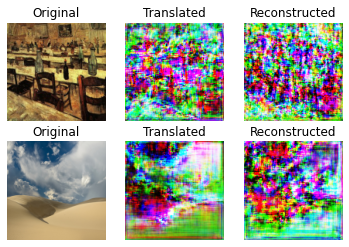

In [8]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=150, batch_size=64, sample_interval=10)